# Algoritmos de clustering

## Alunos

- João Vitor Vendemiato Fatoretto - 199944
- Natan Beltrão da Cunha Pevidor Carvalho - 184972

## Resumo

Neste projeto, implementamos dois algoritmos não-supervisionados de clustering: k-means e dbscan. Executamos os algoritmos em duas bases de dados: uma bidimensional fornecida no enunciado do projeto e uma fornecida pelo site Our World in Data de dados sobre COVID-19, disponível em https://ourworldindata.org/coronavirus.

In [1]:
import matplotlib.pyplot as plot
import numpy as np
import scipy.spatial.distance as spsd
import sklearn
import json
from sklearn.decomposition import PCA

## Dados bi-dimensionais

O primeiro passo foi separar os dados utilizados para treinamento dos modelos e os dados que serão usados para validação dos mesmos.

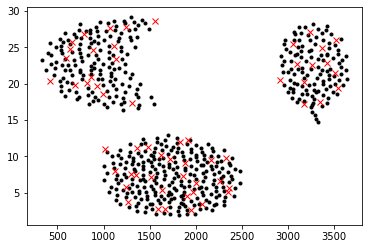

In [2]:
data = np.loadtxt('cluster.dat')

testing = np.array([ item for index, item in enumerate(data) if index % 10 == 0 ])
training = np.array([ item for index, item in enumerate(data) if index % 10 >= 1 ])

plot.plot(training[:,0], training[:,1], '.', color='black')
plot.plot(testing[:,0], testing[:,1], 'x', color='red')
plot.show()

## K-means

Em seguida, implementamos o algoritmo k-means, que separa os dados em clusters caracterizados por um ponto central. Para inicializar o algoritmo, é necessário um parâmetro **k**, que determina quantos clusters diferentes serão gerados.

O primeiro passo é gerar **k** pontos para definirem os clusters inicialmente. Para isso, adotamos a inicialização da implementação k-means++. Nela, o primeiro ponto é escolhido aleatoriamente dentre os dados fornecidos e os próximos também são escolhidos de forma aleatória, porém com maior chance quantos mais distante estiver dos outros pontos já escolhidos.

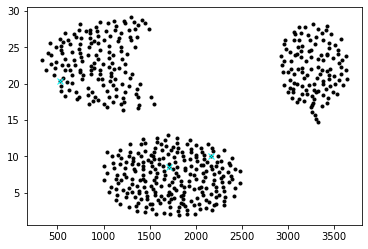

In [3]:
def pick_cluster_centers(array, k):
    centers = []
    for i in range(k):
        p_dist = np.ones(array.shape[0])
        for j in range(array.shape[0]):
            if centers:
                distances = spsd.cdist(np.array([array[j]]), centers)
                p_dist[j] = min(distances)[0]
        p_dist /= sum(p_dist)
        ai = np.random.choice(array.shape[0], p = p_dist)
        centers.append(array[ai])
    return np.array(centers)

centers = pick_cluster_centers(training, 3)

plot.plot(training[:,0], training[:,1], '.', color='black')
plot.plot(centers[:,0], centers[:,1], 'x', color='cyan')
plot.show()

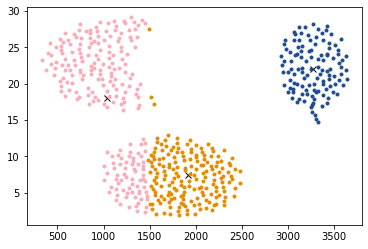

In [4]:
def get_points_clusters_kmeans(array, centers):
    distances = spsd.cdist(array, centers)
    clusterization = np.argmin(distances, axis=1)
    return clusterization

def get_cluster_data_kmeans(array, centers):
    clusterization = get_points_clusters_kmeans(array, centers)
    clusters = {}
    for i in range(centers.shape[0]):
        indices = np.where(clusterization == i)
        clusters[i] = np.take(array, indices, 0)
    return clusters

def kmeans(array, k, diff=0.1):
    centers = pick_cluster_centers(array, k)

    changed = True
    while (changed):
        clusters = get_cluster_data_kmeans(array, centers)
        
        new_centers = np.empty(centers.shape)
        for i in range(k):
            new_centers[i] = np.mean(clusters[i], 1)
        
        if abs(np.sum(new_centers - centers)) > diff:
            centers = new_centers
        else:
            changed = False
    return centers

cluster_centers = kmeans(training, 3)
clusters = get_cluster_data_kmeans(training, cluster_centers)
plot.plot(cluster_centers[:,0], cluster_centers[:,1], 'x', color='black')
for i in clusters:
    plot.plot(clusters[i][0,:,0], clusters[i][0,:,1], '.', color=np.random.rand(3,))
plot.show()

Por fim, normalizamos os dados para que as features do 

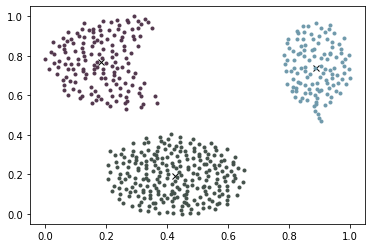

In [5]:
def normalize(array):
    min_by_feature = array.min(axis=0)
    max_by_feature = array.max(axis=0)
    
    normalized_array = array.copy()
    
    for j in range(0, len(array[0])):
        for i in range(0, len(array)):
            normalized_array[i, j] = (array[i, j] - min_by_feature[j]) / (max_by_feature[j] - min_by_feature[j])
    
    return normalized_array

new_training = normalize(training)
new_centers = kmeans(new_training, 3, 0.001)
new_clusters = get_cluster_data_kmeans(new_training, new_centers)

plot.plot(new_centers[:,0], new_centers[:,1], 'x', color='black')
for i in new_clusters:
    plot.plot(new_clusters[i][0,:,0], new_clusters[i][0,:,1], '.', color=np.random.rand(3,))
plot.show()

## DBSCAN

A seguir implementamos o método dbscan, uma alternativa ao k-means para gerar a clusterização dos dados.

O método dbscan inicia separando os dados no centro de um cluster dos dados na borda. Para isso, precisamos informar dois parâmetros:

- **e**: o raio usado para decidir se dois pontos são vizinhos
- **m**: a quantidade de vizinhos necessária para que um ponto seja considerado central

IndexError: too many indices for array

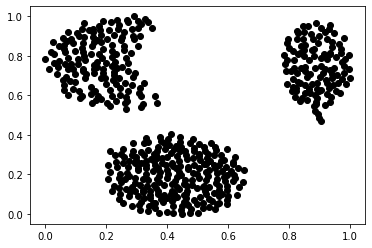

In [6]:
def get_core_points(array, e, m):
    cores = []
    distances = spsd.cdist(array, array)
    for i in range(distances.shape[0]):
        neighbors = np.where(distances[i] < e)
        if neighbors[0].size - 1 >= m:
            cores.append(array[i])
    return np.array(cores)

cores = get_core_points(new_training, 0.005, 13)

plot.plot(new_training[:,0], new_training[:,1], 'o', color='black')
plot.plot(cores[:,0], cores[:,1], '.', color='red')
plot.show()

Após testar alguns valores, optamos pelos valores 0.005 para **e** e 13 para **m**. Após isso, implementamos o restante do algoritmos do dbscan, que agrupa pontos centrais vizinhos em clusters.

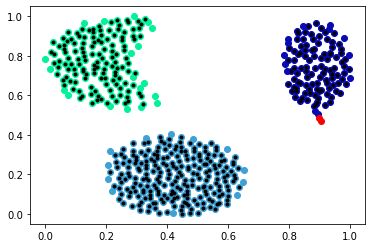

In [8]:
def get_cluster(clusters, core):
    for i in range(len(clusters)):
        for c in clusters[i]:
            if np.array_equal(c, core):
                return i
    return None

def add_core_to_cluster(clusters, cores, neighbors, core_index, cluster_index = None):
    if get_cluster(clusters, cores[core_index]) is not None:
        return
    
    if cluster_index is None:
        clusters.append([cores[core_index]])
        cluster_index = len(clusters) - 1
    else:
        clusters[cluster_index].append(cores[core_index])
    
    for i in range(neighbors[core_index].size):
        add_core_to_cluster(clusters, cores, neighbors, neighbors[core_index][i], cluster_index)

def dbscan(array, e, m):
    cores = get_core_points(array, e, m)
    distances = spsd.cdist(cores, cores)
    neighbors = []
    for i in range(distances.shape[0]):
        neighbors.append(np.where(distances[i] < e)[0])
    
    clusters = []
    for i in range(cores.shape[0]):
        add_core_to_cluster(clusters, cores, neighbors, i)
    
    for i in range(len(clusters)):
        clusters[i] = np.array(clusters[i])
    return clusters

def get_points_cluster_dbscan(array, cores):
    cluster_distances = []
    for i in range(len(cores)):
        distances = spsd.cdist(array, cores[i])
        cluster_distances.append(np.min(distances, axis=1))
    cluster_distances = np.array(cluster_distances)
    clusterization = np.argmin(cluster_distances, axis=0)
    
    return clusterization, cluster_distances

def get_cluster_data_dbscan(array, cores, e):
    clusterization, cluster_distances = get_points_cluster_dbscan(array, cores)
    
    clusters = {}
    outliers = []
    for i in range(len(cores)):
        clusters[i] = []
    
    for i in range(clusterization.size):
        if cluster_distances[clusterization[i],i] < e:
            clusters[clusterization[i]].append(array[i])
        else:
            outliers.append(array[i])
    
    for i in range(len(cores)):
        indices = np.where(clusterization == i)
        clusters.append(np.take(array, indices, 0))
    return clusters

cluster_cores = dbscan(new_training, 0.005, 13)
clusters = get_cluster_data_dbscan(new_training, cluster_cores, 0.005)

for i in range(len(clusters)):
    plot.plot(clusters[i][0,:,0], clusters[i][0,:,1], 'o', color=np.random.rand(3,))
    plot.plot(cluster_cores[i][:,0], cluster_cores[i][:,1], '.', color='black')

if outliers.size:
    plot.plot(outliers[:,0], outliers[:,1], 'o', color='red')

plot.show()

Uma diferença importante entre os métodos k-means e dbscan é que o dbscan é capaz de detectar outliers, isto é, dados que não estão a uma distância **e** de nenhum centro de cluster. Podemos identificar no gráfico (em vermelho) dois pontos que foram identificados como outliers.

## Dados multidimensionais

Para nossos dados multidimensionais, escolhemos os dados fornecidos pelo site Our World in Data (https://ourworldindata.org/coronavirus). Optamos por classificar os países por total de mortos por mês. Como esses dados não estavam disponíveis de forma direta, tivemos que implementar o seguinte algoritmo para obtê-los:

In [8]:
def covid_dataset_cleaner(file_path):
    with open(file_path, 'r') as json_file:
        data = json.load(json_file)

    matriz = {}
    notCountries = ["World", "Africa", "Europe", "European Union", "Asia", "North America", "South America", "Oceania", "International"]

    for country in data:
        if not (data[country]['location'] in notCountries):
            location = data[country]['location']
            newCountry = []
            
            lastMonth = str(data[country]['data'][0]['date'][5]) + str(data[country]['data'][0]['date'][6]) + '/' + str(data[country]['data'][0]['date'][2]) + str(data[country]['data'][0]['date'][3])
            lastData = []
            
            if lastMonth == '04/20':
                newCountry.append([0, '2020-03-31'])
            
            elif lastMonth == '05/20':
                newCountry.append([0, '2020-03-31'])
                newCountry.append([0, '2020-04-30'])

            for daysInformation in data[country]['data']:
                newMonth = str(daysInformation['date'][5]) + str(daysInformation['date'][6]) + '/' + str(daysInformation['date'][2]) + str(daysInformation['date'][3])

                if newMonth == '01/20' or newMonth == '02/20':
                    lastMonth = '03/20'
                    continue

                if lastMonth != newMonth:
                    newCountry.append(lastData)

                deaths = 0
                total_deaths = 0
                if 'total_deaths_per_million' in daysInformation:
                    total_deaths = daysInformation['total_deaths_per_million']
                    if len(newCountry):
                        deaths = total_deaths - newCountry[len(newCountry) - 1][1]
                    else:
                        deaths = total_deaths

                lastMonth = newMonth
                lastData =  [deaths, daysInformation['date']]
                
            if len(newCountry) == 13:
                matriz[location] = newCountry

    return matriz


covid_dataset = covid_dataset_cleaner('covid-data.json')

countries = list(covid_dataset.keys())
deaths = []
for country in countries:
    deaths.append([])
    i = len(deaths) - 1
    for death_data in covid_dataset[country]:
        deaths[i].append(death_data[0])
deaths = np.array(deaths)

{'Afghanistan': [[4.0, '2020-03-31'], [64.0, '2020-04-30'], [258.0, '2020-05-31'], [752.0, '2020-06-30'], [1284.0, '2020-07-31'], [1403.0, '2020-08-31'], [1460.0, '2020-09-30'], [1538.0, '2020-10-31'], [1795.0, '2020-11-30'], [2191.0, '2020-12-31'], [2400.0, '2021-01-31'], [2443.0, '2021-02-28'], [2484.0, '2021-03-31']], 'Albania': [[15.0, '2020-03-31'], [31.0, '2020-04-30'], [33.0, '2020-05-31'], [62.0, '2020-06-30'], [157.0, '2020-07-31'], [284.0, '2020-08-31'], [387.0, '2020-09-30'], [509.0, '2020-10-31'], [810.0, '2020-11-30'], [1181.0, '2020-12-31'], [1380.0, '2021-01-31'], [1796.0, '2021-02-28'], [2235.0, '2021-03-31']], 'Algeria': [[44.0, '2020-03-31'], [450.0, '2020-04-30'], [653.0, '2020-05-31'], [912.0, '2020-06-30'], [1210.0, '2020-07-31'], [1510.0, '2020-08-31'], [1736.0, '2020-09-30'], [1964.0, '2020-10-31'], [2431.0, '2020-11-30'], [2756.0, '2020-12-31'], [2891.0, '2021-01-31'], [2983.0, '2021-02-28'], [3093.0, '2021-03-31']], 'Andorra': [[12.0, '2020-03-31'], [42.0, '202

Para validarmos os algoritmos, precisamos novamente separar os dados de treino dos dados de teste. Também normalizamos os dados separados previamente.

In [9]:
testing_countries = countries[0::10]
testing_deaths = normalize(np.array([ item for index, item in enumerate(deaths) if index % 10 == 0 ]))

training_countries = [country for country in countries if country not in testing_countries]
training_deaths = normalize(np.array([ item for index, item in enumerate(deaths) if index % 10 >= 1 ]))
print("Testing:")
print(testing_countries)
print()
print("Training:")
print(training_countries)

Testing:
['Afghanistan', 'Azerbaijan', 'Bolivia', 'Canada', "Cote d'Ivoire", 'Ecuador', 'France', 'Guinea-Bissau', 'Iraq', 'Kuwait', 'Luxembourg', 'Moldova', 'New Zealand', 'Papua New Guinea', 'Saint Kitts and Nevis', 'Singapore', 'Suriname', 'Trinidad and Tobago', 'Vatican']

Training:
['Albania', 'Algeria', 'Andorra', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Brunei', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Cape Verde', 'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia', 'Comoros', 'Congo', 'Costa Rica', 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Democratic Republic of Congo', 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'Gabon', 'Gambia', 'Geor

## K-means

Em seguida, vamos classificar os países utilizando o método k-means. Para determinar o valor de **k**, utilizamos o método das silhuetas.

In [10]:
centers = kmeans(training_deaths, 5, diff=0.00001)
print(spsd.cdist(centers, centers))
clusters = get_cluster_data_kmeans(training_deaths, centers)
for i in clusters:
    print(clusters[i].shape)

[[0.         0.95432831 0.80549595 0.79997252 0.52749084]
 [0.95432831 0.         1.24929418 1.10951884 1.21209046]
 [0.80549595 1.24929418 0.         0.95504034 1.29649131]
 [0.79997252 1.10951884 0.95504034 0.         1.09704748]
 [0.52749084 1.21209046 1.29649131 1.09704748 0.        ]]
(1, 29, 13)
(1, 6, 13)
(1, 12, 13)
(1, 11, 13)
(1, 109, 13)


## DBSCAN

A seguir, classificamos os países utilizando o método DBSCAN.

In [11]:
cores = dbscan(training_deaths, 0.1, 2)
clusters, outliers = get_cluster_data_dbscan(training_deaths, cores, 0.1)
print(len(cores))
print(len(outliers))

2
79


## PCA

Como os dados que estamos classificando possuem 13 dimensões, não conseguimos representar eles em um gráfico como fizemos com os dados iniciais. Além disso, por causa da alta dimensão, as distâncias entre os pontos podem acabar muito grandes, o que impacta o desempenho do algoritmo k-means.

Para resolver esses problemas, utilizamos o algoritmo PCA, que reduz as dimensões de um conjunto de pontos. Podemos observar o gráfico abaixo demonstrando os dados obtidos reduzindo a dimensão dos dados de 13 para 2.

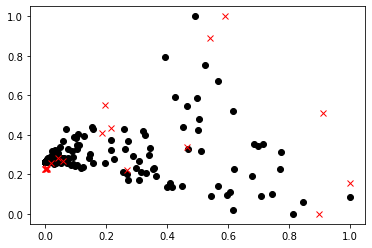

In [12]:
pca = PCA(n_components=2)
pca.fit(normalize(deaths))
training_deaths_2D = normalize(pca.transform(training_deaths))
testing_deaths_2D = normalize(pca.transform(testing_deaths))

plot.plot(training_deaths_2D[:,0], training_deaths_2D[:,1], 'o', color='black')
plot.plot(testing_deaths_2D[:,0], testing_deaths_2D[:,1], 'x', color='red')
plot.show()

Com isso, podemos rodar o método k-means novamente para verificar o impacto do PCA.

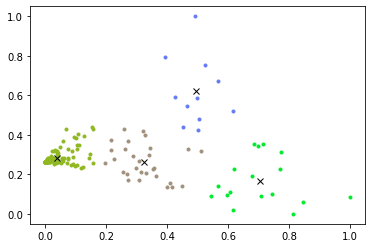

In [13]:
cluster_centers = kmeans(training_deaths_2D, 4, 0.00001)
clusters = get_cluster_data_kmeans(training_deaths_2D, cluster_centers)
for i in clusters:
    plot.plot(clusters[i][0,:,0], clusters[i][0,:,1], '.', color=np.random.rand(3,))
plot.plot(cluster_centers[:,0], cluster_centers[:,1], 'x', color='black')
plot.show()

c:\python37\lib\site-packages\numpy\core\fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\python37\lib\site-packages\numpy\core\_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


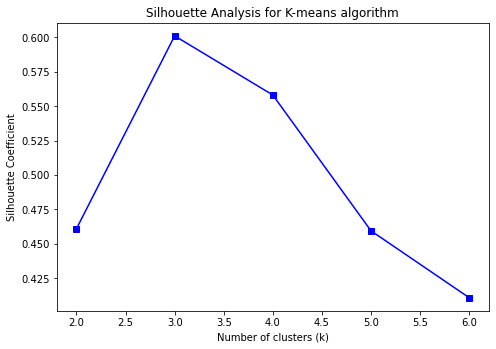

In [16]:
def silhouette_analysis(dataset, points_clusters):    
    
    silhouette_samples = sklearn.metrics.silhouette_samples(dataset, points_clusters)
    silhouette_score = sklearn.metrics.silhouette_score(dataset, points_clusters)
    
    return silhouette_score, silhouette_samples

def silhouette_kmeans(dataset, k):
    total_silhouette_score = np.array([])
    
    for i in range(2, k+1):
        silhouette_score = 0
        for j in range (1, 10):
            cluster_centers = kmeans(normalized_training, i)
            clusters = get_cluster_data_kmeans(training, cluster_centers)
            points_clusters = get_points_clusters_kmeans(normalized_training, cluster_centers)
            score, samples = silhouette_analysis(normalized_training, points_clusters)
            
            silhouette_score += score
            
        silhouette_score = silhouette_score / j
        total_silhouette_score = np.append(total_silhouette_score, silhouette_score)
    
    return total_silhouette_score
    

normalized_training = normalize(training)
silhouette_scores = silhouette_kmeans(normalized_training, 6)

fig = plot.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.plot([2, 3, 4, 5, 6], silhouette_scores, 'bs-')
ax.set_title("Silhouette Analysis for K-means algorithm")
ax.set_xlabel('Number of clusters (k)')
ax.set_ylabel('Silhouette Coefficient')

plot.show()
